<a href="https://colab.research.google.com/github/Jax45/Deepfake-Detection/blob/main/DeepFake_Detection_Phase_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5390 Deep Learning UMSL
## sp21 Semester Project
### Jackson Hoenig



#Imports

In [1]:
import requests, zipfile, io, os
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix


# Prevent google colab from stalling

In [ ]:
import IPython
from google.colab import output

display(IPython.display.Javascript('''
 function ClickConnect(){
   btn = document.querySelector("colab-connect-button")
   if (btn != null){
     console.log("Click colab-connect-button"); 
     btn.click() 
     }
   
   btn = document.getElementById('ok')
   if (btn != null){
     console.log("Click reconnect"); 
     btn.click() 
     }
  }
  
setInterval(ClickConnect,60000)
'''))

print("Done.")

<IPython.core.display.Javascript object>

Done.


# Loading the data

In [2]:


print('Downloading and unzipping test file.')
r = requests.get('https://github.com/Jax45/Deepfake-Detection/raw/main/DeepfakeDataset-001.zip')
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

#Separate the data into Train, Validatation, and Test folders
 while maintaining the difference between fake and real image.

In [3]:
#create the directory paths
!mkdir SplitDataset
!mkdir SplitDataset/train
!mkdir SplitDataset/test
!mkdir SplitDataset/valid
!mkdir SplitDataset/train/real
!mkdir SplitDataset/train/fake
!mkdir SplitDataset/test/real
!mkdir SplitDataset/test/fake
!mkdir SplitDataset/valid/real
!mkdir SplitDataset/valid/fake
!mkdir FullDataset
!mkdir FullDataset/real
!mkdir FullDataset/fake

In [4]:
#in case needs to be reset.
# !rm SplitDataset/train/real/*
# !rm SplitDataset/train/fake/*
# !rm SplitDataset/test/real/*
# !rm SplitDataset/test/fake/*
# !rm SplitDataset/valid/real/*
# !rm SplitDataset/valid/fake/*

In [5]:

#save all real file names to list
import os
count = 0
realFileNames = list()
fakeFileNames = list()
for filename in os.listdir('/content/Real_Images'):
  realFileNames.append(filename)

#save all fake file names to list
for filename in os.listdir('/content/Fake_Images'):
  fakeFileNames.append(filename)



In [6]:
print(len(realFileNames))
print(len(fakeFileNames))

503
361


In [7]:
import random
import os
import imageio
#split real file names into
#train valid and test
random.shuffle(realFileNames)
count = 0
for file in realFileNames:
  imageio.imwrite('/content/FullDataset/real/' + file, imageio.imread('/content/Real_Images/' + file))
  if count < len(realFileNames) * 3 / 5: #first 60%
    # print("Train dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/train/real/' + file, imageio.imread('/content/Real_Images/' + file))

  elif count < len(realFileNames) * 4 / 5: #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/real/' + file, imageio.imread('/content/Real_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/real/' + file, imageio.imread('/content/Real_Images/' + file))

  count += 1;
#same with fake
random.shuffle(fakeFileNames)
count = 0
for file in fakeFileNames:
  imageio.imwrite('/content/FullDataset/fake/' + file, imageio.imread('/content/Fake_Images/' + file))
  if count < len(fakeFileNames) * 3 / 5: #first 60%
    # print("Train dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/train/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  elif count < len(fakeFileNames) * 4 / 5: #20% after 60%
    # print("Valid dataset" + str(count))
    imageio.imwrite('/content/SplitDataset/valid/fake/' + file, imageio.imread('/content/Fake_Images/' + file))

  else: #Last 20 percent
    #Test
    imageio.imwrite('/content/SplitDataset/test/fake/' + file, imageio.imread('/content/Fake_Images/' + file))
  
  count += 1;


In [8]:
base_dir = 'SplitDataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

for s in os.listdir(base_dir):
  for origin in os.listdir(base_dir+'/'+s):
    print(base_dir+'/'+s+'/'+origin+': '+str(len(os.listdir(base_dir+'/'+s+'/'+origin))))
  print('-----')

SplitDataset/test/real: 100
SplitDataset/test/fake: 72
-----
SplitDataset/valid/real: 101
SplitDataset/valid/fake: 72
-----
SplitDataset/train/real: 302
SplitDataset/train/fake: 217
-----


# Overfitting Model with all the data

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from keras import layers
from keras import models
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np

full_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=10,
    brightness_range=[0.8,1.2],
    fill_mode='nearest' 
    )

full_generator = full_datagen.flow_from_directory(
        '/content/FullDataset',
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical',
        color_mode='grayscale')
class_dictionary = full_generator.class_indices
print(class_dictionary)

Found 864 images belonging to 2 classes.
{'fake': 0, 'real': 1}


In [10]:
#get a validation set generator
validate_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validate_datagen.flow_from_directory(
        validation_dir,
        target_size=(256, 256),
        batch_size=4,
        class_mode='categorical',
        color_mode='grayscale')

Found 173 images belonging to 2 classes.


In [ ]:
# #trying to switch to binary
# full_datagen = ImageDataGenerator(rescale=1./255,
#     rotation_range=10,
#     brightness_range=[0.8,1.2],
#     fill_mode='nearest' 
#     )

# full_generator = full_datagen.flow_from_directory(
#         '/content/FullDataset',
#         target_size=(256, 256),
#         batch_size=4,
#         class_mode='binary',
#         color_mode='grayscale')
# class_dictionary = full_generator.class_indices
# print(class_dictionary)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

modelOverfit = Sequential()
modelOverfit.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit.add( MaxPool2D(4, 4) )
modelOverfit.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
modelOverfit.add( MaxPool2D(4, 4) )
modelOverfit.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelOverfit.add( Flatten() )
modelOverfit.add( Dense( 10, activation = 'relu' ) )
modelOverfit.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 61, 61, 32)        18464     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 13, 13, 16)        4624      
_________________________________________________________________
flatten_11 (Flatten)         (None, 2704)              0         
_________________________________________________________________
dense_21 (Dense)             (None, 10)              

In [ ]:
modelOverfit.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )

In [ ]:
history = modelOverfit.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Epoch 1/25
216/216 [==============================] - 7s 29ms/step - loss: 0.6767 - accuracy: 0.6081 - val_loss: 0.5365 - val_accuracy: 0.5838
Epoch 2/25
216/216 [==============================] - 6s 29ms/step - loss: 0.5453 - accuracy: 0.6911 - val_loss: 0.4521 - val_accuracy: 0.8497
Epoch 3/25
216/216 [==============================] - 6s 29ms/step - loss: 0.4749 - accuracy: 0.8063 - val_loss: 0.4103 - val_accuracy: 0.8902
Epoch 4/25
216/216 [==============================] - 6s 29ms/step - loss: 0.4465 - accuracy: 0.8198 - val_loss: 0.3173 - val_accuracy: 0.8960
Epoch 5/25
216/216 [==============================] - 6s 29ms/step - loss: 0.3588 - accuracy: 0.9019 - val_loss: 0.2702 - val_accuracy: 0.9422
Epoch 6/25
216/216 [==============================] - 6s 29ms/step - loss: 0.3315 - accuracy: 0.9008 - val_loss: 0.2495 - val_accuracy: 0.9711
Epoch 7/25
216/216 [==============================] - 6s 29ms/step - loss: 0.3152 - accuracy: 0.9098 - val_loss: 0.2336 - val_accuracy: 0.9827

# Data Generator Output as Input

In [11]:
# Empty placeholders for 2000 Grayscale images and their labels
mydatax = np.zeros((2000, 256, 256, 1))
mydatay = np.zeros((2000, 2))
# Read everything from your generator
i = 0;
j = 0;
maxI = 2000 / 4
for x, y in full_generator:
  #  print(x.shape)
  #  print(y)
  #  print(mydatax[j, :, :].shape)
   mydatax[j] = x[0]
   mydatay[j] = y[0]
   j+=1

   mydatax[j] = x[1]
   mydatay[j] = y[1]
   j+=1
   mydatax[j] = x[2]
   mydatay[j] = y[2]
   j+=1
   mydatax[j] = x[3]
   mydatay[j] = y[3]
   j+=1
   i+=1
   if i == maxI:
     break

In [12]:
print(mydatax.shape)
print(mydatay.shape)

(2000, 256, 256, 1)
(2000, 2)


In [13]:
print(mydatay[:20])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [14]:
#newDataY = categorical to binary
newDataY = np.zeros((2000, 1))
for i, yPair in enumerate(mydatay):
  if yPair[0] == 0:
    newDataY[i] = 0
  else:
    newDataY[i] = 1

In [15]:
print(newDataY[:20])
print(mydatay[:20])


[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
[[1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# # Example of how to use output labels as additional input channel
# import numpy as np
# N = len(mydatax[:, 0, 0, 0])
# L = len(mydatax[0, :, 0, 0])
# xtrain_with_outputlabels = np.zeros((N, L, L, 2))
# for i in range(len(mydatax)):
#    existing = mydatax[i, :, :, :]
#    newchannel = np.full((L, L), newDataY[i])
#    newchannel = newchannel.reshape(L, L, 1)
#    x = np.concatenate((existing, newchannel), axis = -1)
#    print(existing.shape, newchannel.shape, x.shape)
#    xtrain_with_outputlabels[i] = x
#    break

In [ ]:
# import numpy as np
# N = len(mydatax[:, 0, 0, 0])
# L = len(mydatax[0, :, 0, 0])
# xtrain_with_outputlabels = np.zeros((N, L, L, 1))
# #append newDataY to mydatax
# print(mydatax.shape)
# print(newDataY.shape)
# xtrain_with_outputlabels = np.concatenate((mydatax, newDataY), axis=-1) #axis is 3 since we already have 4 columns we want a fourth

In [16]:
N = len(mydatax[:, 0, 0, 0])
L = len(mydatax[0, :, 0, 0])
xtrain_with_outputlabels = np.zeros((N, L, L, 2))
for i in range(N): #runs for 2000
  # print(mydatax[i,:,:,0].shape)
  # print(xtrain_with_outputlabels[i,:,:,0].shape)
  xtrain_with_outputlabels[i, :, :, 0] = mydatax[i,:,:,0]
  xtrain_with_outputlabels[i, :, :, 1] = newDataY[i]


In [17]:
xtrain_with_outputlabels[0, :, :, :].shape

(256, 256, 2)

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D

model = Sequential()
model.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape ) )
model.add( MaxPool2D(4, 4) )
model.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
model.add( MaxPool2D(4, 4) )
model.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model.add( Flatten() )
model.add( Dense( 10, activation = 'relu' ) )
model.add( Dense( 1, activation = 'sigmoid' ) )
model.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )


In [ ]:
# Train using the training set and evaluate using the validation set
historyOutputInput = model.fit( xtrain_with_outputlabels, newDataY, epochs = 5, batch_size = 64 )

Epoch 1/5
32/32 [==============================] - 37s 89ms/step - loss: 0.3477 - accuracy: 0.8663
Epoch 2/5
32/32 [==============================] - 3s 81ms/step - loss: 1.8713e-06 - accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 3s 80ms/step - loss: 3.0931e-08 - accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 3s 80ms/step - loss: 1.3857e-08 - accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 3s 80ms/step - loss: 2.2460e-08 - accuracy: 1.0000


**We overfit in 2 epoches here, so we can definetly decrease the model size and still overfit I think.**




In [ ]:
model2 = Sequential()
model2.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape ) )
model2.add( MaxPool2D(4, 4) )
model2.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
model2.add( Flatten() )
model2.add( Dense( 10, activation = 'relu' ) )
model2.add( Dense( 1, activation = 'sigmoid' ) )
model2.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyOutputInput2 = model2.fit( xtrain_with_outputlabels, newDataY, epochs = 5, batch_size = 64 )

Epoch 1/5
32/32 [==============================] - 4s 74ms/step - loss: 0.1077 - accuracy: 0.9361
Epoch 2/5
32/32 [==============================] - 2s 65ms/step - loss: 1.1847e-11 - accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 2s 66ms/step - loss: 2.6868e-12 - accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 2s 65ms/step - loss: 2.6223e-12 - accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 2s 65ms/step - loss: 5.9888e-12 - accuracy: 1.0000


**Still overfitting.**

In [ ]:
model3 = Sequential()
model3.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape ) )
model3.add( Flatten() )
model3.add( Dense( 10, activation = 'relu' ) )
model3.add( Dense( 1, activation = 'sigmoid' ) )
model3.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyOutputInput3 = model3.fit( xtrain_with_outputlabels, newDataY, epochs = 5, batch_size = 64 )

Epoch 1/5
32/32 [==============================] - 3s 53ms/step - loss: 0.0806 - accuracy: 0.9380
Epoch 2/5
32/32 [==============================] - 2s 47ms/step - loss: 4.1358e-16 - accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 2s 48ms/step - loss: 2.5116e-16 - accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 1s 47ms/step - loss: 1.7392e-16 - accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 2s 48ms/step - loss: 4.0300e-16 - accuracy: 1.0000


In [ ]:
model4 = Sequential()
model4.add( Conv2D( 16, ( 3, 3 ), activation = 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape ) )
model4.add( Flatten() )
model4.add( Dense( 1, activation = 'sigmoid' ) )
model4.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyOutputInput4 = model4.fit( xtrain_with_outputlabels, newDataY, epochs = 5, batch_size = 64 )

Epoch 1/5
32/32 [==============================] - 35s 48ms/step - loss: 0.0769 - accuracy: 0.9632
Epoch 2/5
32/32 [==============================] - 1s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 1s 43ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 1s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 1s 44ms/step - loss: 0.0000e+00 - accuracy: 1.0000


In [ ]:
model5 = Sequential()
model5.add( Conv2D( 8, ( 3, 3 ), activation = 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape ) )
model5.add( Flatten() )
model5.add( Dense( 1, activation = 'sigmoid' ) )
model5.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyOutputInput5 = model5.fit( xtrain_with_outputlabels, newDataY, epochs = 5, batch_size = 64 )

Epoch 1/5
32/32 [==============================] - 2s 37ms/step - loss: 0.0871 - accuracy: 0.9264
Epoch 2/5
32/32 [==============================] - 1s 33ms/step - loss: 1.9171e-23 - accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 1s 33ms/step - loss: 3.0478e-23 - accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 1s 32ms/step - loss: 1.2278e-23 - accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 1s 32ms/step - loss: 1.8814e-23 - accuracy: 1.0000


In [ ]:
model6 = Sequential()
model6.add( Conv2D( 2, ( 3, 3 ), activation = 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape ) )
model6.add( Flatten() )
model6.add( Dense( 1, activation = 'sigmoid' ) )
model6.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyOutputInput6 = model6.fit( xtrain_with_outputlabels, newDataY, epochs = 5, batch_size = 64 )

Epoch 1/5
32/32 [==============================] - 2s 27ms/step - loss: 0.0630 - accuracy: 0.9542
Epoch 2/5
32/32 [==============================] - 1s 23ms/step - loss: 1.2489e-30 - accuracy: 1.0000
Epoch 3/5
32/32 [==============================] - 1s 23ms/step - loss: 9.7462e-32 - accuracy: 1.0000
Epoch 4/5
32/32 [==============================] - 1s 23ms/step - loss: 3.2233e-31 - accuracy: 1.0000
Epoch 5/5
32/32 [==============================] - 1s 23ms/step - loss: 3.3972e-31 - accuracy: 1.0000


In [25]:
model7 = Sequential()
model7.add( Dense( 1, activation = 'relu', input_shape = xtrain_with_outputlabels[0, :, :, :].shape ) )
model7.add( Flatten())
model7.add( Dense( 1, activation = 'sigmoid' ) )
model7.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
historyOutputInput7 = model7.fit( xtrain_with_outputlabels, newDataY, epochs = 25, batch_size = 64 )

Epoch 1/25
32/32 [==============================] - 1s 20ms/step - loss: 1.3190 - accuracy: 0.5237
Epoch 2/25
32/32 [==============================] - 1s 21ms/step - loss: 0.3475 - accuracy: 0.8800
Epoch 3/25
32/32 [==============================] - 1s 20ms/step - loss: 0.2485 - accuracy: 0.9028
Epoch 4/25
32/32 [==============================] - 1s 21ms/step - loss: 0.1768 - accuracy: 0.9399
Epoch 5/25
32/32 [==============================] - 1s 20ms/step - loss: 0.1534 - accuracy: 0.9480
Epoch 6/25
32/32 [==============================] - 1s 21ms/step - loss: 0.1247 - accuracy: 0.9592
Epoch 7/25
32/32 [==============================] - 1s 21ms/step - loss: 0.0982 - accuracy: 0.9759
Epoch 8/25
32/32 [==============================] - 1s 20ms/step - loss: 0.0926 - accuracy: 0.9883
Epoch 9/25
32/32 [==============================] - 1s 21ms/step - loss: 0.0706 - accuracy: 0.9984
Epoch 10/25
32/32 [==============================] - 1s 20ms/step - loss: 0.0628 - accuracy: 0.9960
Epoch 11/

I cannot think of a valid model that could be smaller than this one. At least it does not overfit quite as fast.

# Performance Analysis
Goal: Look at the performance of the models when the number of filters and layers are increased and decreased.

## Create alternate models

In [ ]:
modelOverfit2 = Sequential()
#Increased the input from 64 to 128
modelOverfit2.add( Conv2D( 128, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit2.add( MaxPool2D(4, 4) )
modelOverfit2.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
modelOverfit2.add( MaxPool2D(4, 4) )
modelOverfit2.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelOverfit2.add( Flatten() )
modelOverfit2.add( Dense( 10, activation = 'relu' ) )
modelOverfit2.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit2.summary()
modelOverfit2.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history2 = modelOverfit2.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 254, 254, 128)     1280      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 32)        36896     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 13, 13, 16)        4624      
_________________________________________________________________
flatten_3 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)               

In [ ]:
modelOverfit3 = Sequential()
modelOverfit3.add( Conv2D( 64, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit3.add( MaxPool2D(4, 4) )
#removed this layer
# modelOverfit3.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
# modelOverfit3.add( MaxPool2D(4, 4) )
modelOverfit3.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelOverfit3.add( Flatten() )
modelOverfit3.add( Dense( 10, activation = 'relu' ) )
modelOverfit3.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit3.summary()
modelOverfit3.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history3 = modelOverfit3.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 254, 254, 64)      640       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 61, 61, 16)        9232      
_________________________________________________________________
flatten_4 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                595370    
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 22        
Total params: 605,264
Trainable params: 605,264
Non-trainable params: 0
________________________________________________

In [ ]:
modelOverfit4 = Sequential()
#reduced input size 64 to 48
modelOverfit4.add( Conv2D( 48, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit4.add( MaxPool2D(4, 4) )
modelOverfit4.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
modelOverfit4.add( MaxPool2D(4, 4) )
modelOverfit4.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelOverfit4.add( Flatten() )
modelOverfit4.add( Dense( 10, activation = 'relu' ) )
modelOverfit4.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit4.summary()
modelOverfit4.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history4 = modelOverfit4.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 254, 254, 48)      480       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 63, 63, 48)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 61, 32)        13856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 13, 13, 16)        4624      
_________________________________________________________________
flatten_5 (Flatten)          (None, 2704)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 10)               

In [ ]:
modelOverfit5 = Sequential()
#added a top layer here
modelOverfit5.add( Conv2D( 128, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit5.add( MaxPool2D(4, 4) )
modelOverfit5.add( Conv2D( 64, ( 3, 3 ), activation = 'relu' ) )
modelOverfit5.add( MaxPool2D(4, 4) )
modelOverfit5.add( Conv2D( 32, ( 3, 3 ), activation = 'relu' ) )
modelOverfit5.add( MaxPool2D(4, 4) )
modelOverfit5.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelOverfit5.add( Flatten() )
modelOverfit5.add( Dense( 10, activation = 'relu' ) )
modelOverfit5.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit5.summary()
modelOverfit5.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history5 = modelOverfit5.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 254, 254, 128)     1280      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 63, 63, 128)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 61, 64)        73792     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 13, 13, 32)        18464     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 1, 1, 16)         

In [ ]:
modelOverfit6 = Sequential()
#removed top layer
modelOverfit6.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit6.add( MaxPool2D(4, 4) )
modelOverfit6.add( Conv2D( 16, ( 3, 3 ), activation = 'relu' ) )
modelOverfit6.add( Flatten() )
modelOverfit6.add( Dense( 10, activation = 'relu' ) )
modelOverfit6.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit6.summary()
modelOverfit6.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history6 = modelOverfit6.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 61, 61, 16)        4624      
_________________________________________________________________
flatten_7 (Flatten)          (None, 59536)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                595370    
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 22        
Total params: 600,336
Trainable params: 600,336
Non-trainable params: 0
________________________________________________

In [ ]:
modelOverfit7 = Sequential()
#removed top layer and middle 16 layer
modelOverfit7.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit7.add( MaxPool2D(4, 4) )
modelOverfit7.add( Flatten() )
modelOverfit7.add( Dense( 10, activation = 'relu' ) )
modelOverfit7.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit7.summary()
modelOverfit7.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history7 = modelOverfit7.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)                1270090   
_________________________________________________________________
dense_17 (Dense)             (None, 2)                 22        
Total params: 1,270,432
Trainable params: 1,270,432
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
216/216 [==============================] - 6s 27ms/step - loss: 0.7490 - accuracy: 0.5688 - val_los

In [ ]:
modelOverfit8 = Sequential()
#removed top layer and middle 16 layer and dense 10 layer
modelOverfit8.add( Conv2D( 32, ( 3, 3 ), activation = 'relu', input_shape=(256, 256, 1) ) )
modelOverfit8.add( MaxPool2D(4, 4) )
modelOverfit8.add( Flatten() )
modelOverfit8.add( Dense( 2, activation = 'sigmoid' ) )
modelOverfit8.summary()
modelOverfit8.compile( optimizer = 'adam', loss = 'binary_crossentropy', metrics = [ 'accuracy' ] )
history8 = modelOverfit8.fit( full_generator, validation_data=validation_generator, epochs = 25, batch_size = 64 )

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 254, 254, 32)      320       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 254018    
Total params: 254,338
Trainable params: 254,338
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
216/216 [==============================] - 6s 27ms/step - loss: 0.8661 - accuracy: 0.6461 - val_loss: 0.2646 - val_accuracy: 0.9306
Epoch 2/25
216/216 [==============================] - 6s 27ms/step - loss: 0.3243 - accuracy: 0.8612 - 

## Evaluate new models

In [ ]:
def evaluateModel(model, x, y):
  # predict probabilities for test set
  yhat_probs = model.predict(x, verbose=0)
  # predict crisp classes for test set
  yhat_classes = model.predict_classes(x, verbose=0)
  # print(yhat_classes[:10])
  #round the predictions
  yhat_probs = np.round(yhat_probs)
  # accuracy: (tp + tn) / (p + n)
  accuracy = accuracy_score(y, yhat_probs)
  print('Accuracy: %f' % accuracy)
  # precision tp / (tp + fp)
  precision = precision_score(y, yhat_probs, average='macro')
  print('Precision: %f' % precision)
  # recall: tp / (tp + fn)
  recall = recall_score(y, yhat_probs, average='macro')
  print('Recall: %f' % recall)
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(y, yhat_probs, average='macro')
  print('F1 score: %f' % f1)


In [ ]:
print("First overfitting model")
evaluateModel(modelOverfit, mydatax, mydatay)
print("------------------------------------------------------------")

print("Second overfitting model")
evaluateModel(modelOverfit2, mydatax, mydatay)
print("------------------------------------------------------------")

print("Third overfitting model")
evaluateModel(modelOverfit3, mydatax, mydatay)
print("------------------------------------------------------------")

print("Fourth overfitting model")
evaluateModel(modelOverfit4, mydatax, mydatay)
print("------------------------------------------------------------")

print("Fifth overfitting model")
evaluateModel(modelOverfit5, mydatax, mydatay)
print("------------------------------------------------------------")

print("Sixth overfitting model")
evaluateModel(modelOverfit6, mydatax, mydatay)
print("------------------------------------------------------------")

print("Seventh overfitting model")
evaluateModel(modelOverfit7, mydatax, mydatay)
print("------------------------------------------------------------")

print("Eighth overfitting model")
evaluateModel(modelOverfit8, mydatax, mydatay)


First overfitting model


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy: 0.944000
Precision: 0.955836
Recall: 0.936019
F1 score: 0.942720
------------------------------------------------------------
Second overfitting model
Accuracy: 0.977000
Precision: 0.975512
Recall: 0.977546
F1 score: 0.976478
------------------------------------------------------------
Third overfitting model
Accuracy: 0.963000
Precision: 0.970596
Recall: 0.958305
F1 score: 0.963529
------------------------------------------------------------
Fourth overfitting model
Accuracy: 0.984000
Precision: 0.983945
Recall: 0.987024
F1 score: 0.985268
------------------------------------------------------------
Fifth overfitting model
Accuracy: 0.981000
Precision: 0.982846
Recall: 0.982867
F1 score: 0.982715
------------------------------------------------------------
Sixth overfitting model
Accuracy: 0.578000
Precision: 0.289000
Recall: 0.500000
F1 score: 0.366286
------------------------------------------------------------
Seventh overfitting model


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 0.578000
Precision: 0.289000
Recall: 0.500000
F1 score: 0.366286
------------------------------------------------------------
Eighth overfitting model
Accuracy: 0.995000
Precision: 0.994425
Recall: 0.995355
F1 score: 0.994880


From this data we find that the seventh and sixth models were not good at all.

Also, the best performing overfitting model looks to be either the 8th since the F-1 score is close to 1, and acc and precision and recall are all close as well.

##Plot Learning Curves

In [ ]:
from google.colab import files


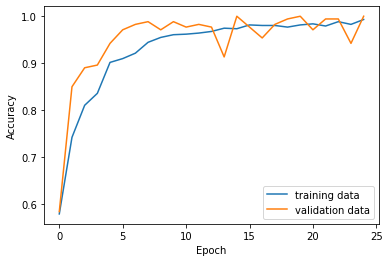

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot1.png")

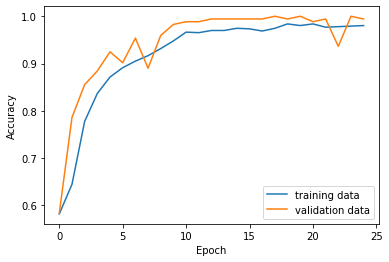

In [ ]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot2.png")

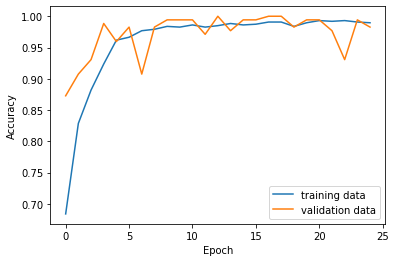

In [ ]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot3.png")

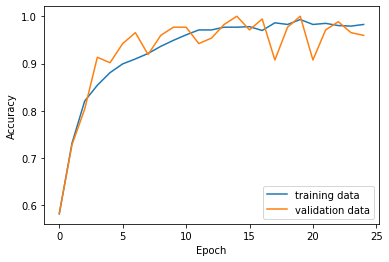

In [ ]:
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot4.png")

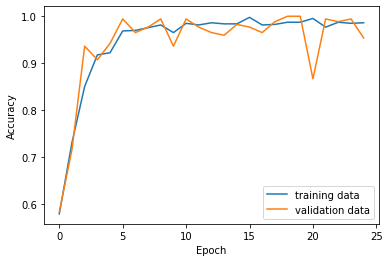

In [ ]:
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot5.png")

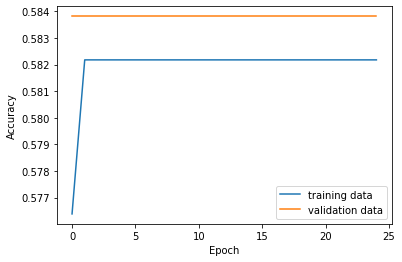

In [ ]:
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot6.png")

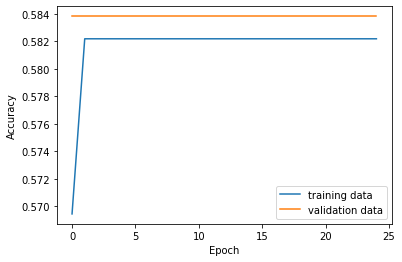

In [ ]:
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot7.png")

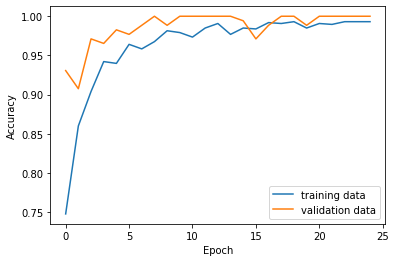

In [ ]:
plt.plot(history8.history['accuracy'])
plt.plot(history8.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['training data', 'validation data'], loc='lower right')
plt.show()
plt.savefig("overfitPlot8.png")

In [29]:
#to download the plots
# files.download("overfitPlot1.png") 
# files.download("overfitPlot2.png") 
# files.download("overfitPlot3.png") 
# files.download("overfitPlot4.png") 
# files.download("overfitPlot5.png") 
# files.download("overfitPlot6.png") 
# files.download("overfitPlot7.png") 
# files.download("overfitPlot8.png") 

# Save the model to a file

In [ ]:
# model.save('deepfakeDetectionModel.h5')
